In [164]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import json
import re
import string

# Tides processing

In [223]:
root_path = os.getcwd()
tides_root_path = os.path.join(root_path, 'tides')
tides_data_path = os.path.join(tides_root_path, 'raw')

In [224]:
tides_root_path

'E:\\#PROJECT\\floodmap\\tides'

In [225]:
tides_data_path

'E:\\#PROJECT\\floodmap\\tides\\raw'

In [23]:
tides_data_list = os.listdir(tides_data_path)

In [24]:
len(tides_data_list)

8210

In [34]:
# Coordinate processor from filename
np.array(tides_data_list[0].split('][')[2].split(',')).astype('float32')

array([ 95.01131 , -10.987473], dtype=float32)

In [100]:
# Extract tides value
extracted_tides = []
coordinates = []
flag_duplicate_coordinate = 0
flag_not_enough_data = 0 
flag_invalid = 0

for i, tides_data in enumerate(tides_data_list):
    tides_file_path = os.path.join(tides_data_path, tides_data)
    # tides_file_path = os.path.join(tides_data_path, '[123][30][138.54195170940173,0.29589898989899055][hasil(2)-1602398717703].txt')
    with open(tides_file_path, 'r') as f:
        data = f.readlines()
        
    coordinate = tides_data.split('][')[2].split(',')
    
    # Check if same coordinate have been processed before
    if coordinate in coordinates:
        flag_duplicate_coordinate += 1
        # print(f'{i}/{len(tides_data_list)} duplicate coordinate')
        continue

    # value = np.array([d.strip()[-5:] for d in data[3:]]).astype('float32')
    # coordinate = np.array(tides_data_list[0].split('][')[2].split(',')).astype('float32')
    
    # Valid tides data:
    # 1. Index 0,1,2 are header
    # 2. Data start from index 3
    # 3. Have at least 360 data (if more are available, trimmed.)
    if len(data) < 363:
        flag_not_enough_data += 1
        # print(f'{i}/{len(tides_data_list)} not enough data')
        continue
    
    value = [d.strip()[-5:] for d in data[3:363]]
    
    # Check if extracted value is valid one, by detecting
    # `*` pattern
    if re.search('\*', value[0]):
        flag_invalid += 1
        # print(f'{i}/{len(tides_data_list)} isn\'t valid')
        continue
    else:
        pass
    
    
    extracted_tides.append([coordinate,value])
    coordinates.append(coordinate)
    if i % 100 == 99:
        print(f'{i}/{len(tides_data_list)}')

# Store to JSON
extracted_tides_filename = 'extracted.json'
extracted_tides_path = os.path.join(tides_root_path, extracted_tides_filename)
with open(extracted_tides_path, 'w') as f:
    json.dump(extracted_tides, f)
    

4699/8210


In [101]:
flag_duplicate_coordinate, flag_not_enough_data, flag_invalid

(3165, 109, 1748)

# Run excel VBA, manipulate cell value, read back cell value

In [228]:
# Write input value
wb = ox.load_workbook(filename=tides_engine_path, read_only=False, keep_vba=True)
inputs = wb['Input']

with open(extracted_tides_path, 'r') as f:
    extracted_tides = json.load(f)

start_row = 9
column_ranges = string.ascii_uppercase[2:]

for i, value in enumerate(extracted_tides[3000][1]):
    if i % (len(column_ranges)) == 0:
        start_row += 1
    
    column = i % len(column_ranges)
    
    cell = f'{column_ranges[column]}{start_row}'
    inputs[cell] = float(value)

wb.save(tides_excel_path)
wb.close()

In [226]:
import win32com.client

tides_engine_path = os.path.join(tides_root_path, 'tides_engine.xlsm')
# tides_excel_path = 'J:\Kuliah\Mata Kuliah\Proteksi Pantai dan Rawa\PrediksiPasut_Teluk Palu - Copy\PrediksiPasut.xlsm'

xl = win32com.client.Dispatch("Excel.Application")

wb = xl.Workbooks.Open(tides_engine_path)
xl.Application.Run('tides_engine.xlsm!Sheet4.cmdRefresh_Click()')

wb.Save()
xl.Application.Quit()

In [229]:
import openpyxl as ox

# Read existing workbook
wb = ox.load_workbook(filename=tides_engine_path, read_only=False, keep_vba=True)
results = wb['Calculation']

Z0 = results['K4'].value
M2 = results['K5'].value
S2 = results['K6'].value
N2 = results['K7'].value
K2 = results['K8'].value
K1 = results['K9'].value
O1 = results['K10'].value
P1 = results['K11'].value
M4 = results['K12'].value
MS4 = results['K13'].value

HHWL = Z0 + S2 + K1 + O1 + P1 + M2 + K2
LLWL = Z0 - (M2 + S2 + N2 + K1 + O1 + P1 + M4 + MS4)
MHWL = Z0 + (M2 + S2)
MLWL = Z0 - (M2 + S2)

print(HHWL, MHWL, Z0, MLWL, LLWL)

wb.close()

0.8029214984271281 0.40161706773386086 0.21142364514928993 0.021230222564719042 -0.37316177895413327


1: 0.5103402630290366 0.24000239396078965 0.21253740617953432 0.18507241839827898 -0.2396688722988668
100: 0.9433209812519656 0.5183703025896438 0.35372692542859147 0.18908354826753915 -0.4143937489349982
500: 0.5520498851993269 0.2561199412571001 0.2018665634657847 0.1476131856744693 -0.2670258279947593
1000: 0.589483074951265 0.2822054405206289 0.20717580564938662 0.1321461707781443 -0.27599377855357965
2000: 0.4674378889654878 0.2088560435286184 0.17832787654229132 0.14779970955596425 -0.23469777330249147
3000: 0.8029214984271281 0.40161706773386086 0.21142364514928993 0.021230222564719042 -0.37316177895413327

360

In [189]:
import openpyxl as ox

# Read existing workbook
wb = ox.load_workbook(filename=tides_engine_path, read_only=False, keep_vba=True)
results = wb['Calculation']

Z0 = results['K4'].value
M2 = results['K5'].value
S2 = results['K6'].value
N2 = results['K7'].value
K2 = results['K8'].value
K1 = results['K9'].value
O1 = results['K10'].value
P1 = results['K11'].value
M4 = results['K12'].value
MS4 = results['K13'].value

HHWL = Z0 + S2 + K1 + O1 + P1 + M2 + K2
LLWL = Z0 - (M2 + S2 + N2 + K1 + O1 + P1 + M4 + MS4)
MHWL = Z0 + (M2 + S2)
MLWL = Z0 - (M2 + S2)

print(HHWL, MHWL, Z0, MLWL, LLWL)

wb.close()

1.4184608264202618 0.9080172405619822 -0.0003460574947640893 -0.9087093555515104 -1.432460338137139


# Demnas grouping by coordinates

In [1]:
import os
import json
import datetime
import PIL
import PIL.Image
import PIL.TiffTags
# from PIL import Image
# from PIL.TiffTags import TAGS
import pandas as pd
import sqlite3
from tqdm.auto import tqdm

In [52]:
class Demnas:
    '''env:ipykernel'''
    def __init__(self):
        self.cwd = os.getcwd()
        self.root = os.path.join(self.cwd, 'demnas')
        self.raw_path = os.path.join(self.root, 'raw')
        self.error_fn = 'demnas_error.json'
        self.error_path = os.path.join(self.root, self.error_fn)
        self.extent_fn = 'extent.db'
        self.extent_path = os.path.join(self.root, self.extent_fn)
        self.extent_table = 'extent'
        
    def raw_data_list(self):
        return os.listdir(self.raw_path)
    
    def get_extent(self, img_path):
        '''Get xy coordinates'''
        img = PIL.Image.open(img_path)
        meta_dict = {PIL.TiffTags.TAGS[key] : img.tag[key] for key in img.tag_v2}
        xmin, ymax = meta_dict['ModelTiepointTag'][3], meta_dict['ModelTiepointTag'][4]
        xmax = xmin + meta_dict['ImageWidth'][0] * meta_dict['ModelPixelScaleTag'][0]
        ymin = ymax - meta_dict['ImageWidth'][0] * meta_dict['ModelPixelScaleTag'][1]
        return xmin, xmax, ymin, ymax
    
    def extract_extent(self):
        error_list = []

        extents = []
        for i, fn in enumerate(tqdm(self.raw_data_list())):
            img_path = os.path.join(self.raw_path, fn)

            try:
                xmin, xmax, ymin, ymax = self.get_extent(img_path)
            except PIL.UnidentifiedImageError:
                error_list.append(fn)
                continue

            extents.append([fn, xmin, xmax, ymin, ymax])

        # Write error log to file
        with open(self.error_path, 'w') as f:
            json.dump(error_list, f)

        # Write dataxy to db
        extents_df = pd.DataFrame(extents)
        extent_con = sqlite3.connect(self.extent_path)
        extents_df.to_sql(self.extent_table, extent_con, if_exists='replace', index=False)
        extent_con.close()
        
    def extents(self):
        if os.path.exists(self.extent_path):
            extent_con = sqlite3.connect(self.extent_path)
            try:
                extent_df = pd.read_sql(f'select * from {self.extent_table}', extent_con)
                return extent_df
            except pd.io.sql.DatabaseError:
                print(f'`{self.extent_table}` table not found in this database. Please run `extract_extent` to solve the problem.')
                return None
        else:
            print(f'No {self.extent_table} found. Please run `extract_extent` first.')
            return None
    
    def error(self):
        if os.path.exists(self.error_path):
            with open(self.error_path, 'r') as f:
                return json.load(f)
        else:
            print('No error file found. Please run `extract_extent` first.')
    

In [53]:
dc = Demnas()

In [50]:
dc.extract_extent()

  0%|          | 0/4781 [00:00<?, ?it/s]

In [54]:
dc.extents()

,0,1,2,3,4
0,0_DEMNAS_1118-631_v1.0.tif,106.000,106.125,2.750,2.875
1,1000_DEMNAS_1319-442_v1.0.tif,108.375,108.500,3.750,3.875
2,1001_DEMNAS_1319-441_v1.0.tif,108.250,108.375,3.750,3.875
3,1002_DEMNAS_1319-432_v1.0.tif,108.125,108.250,3.750,3.875
4,1003_DEMNAS_1319-431_v1.0.tif,108.000,108.125,3.750,3.875
...,...,...,...,...,...
4751,997_DEMNAS_1119-321_v1.0.tif,106.250,106.375,3.000,3.125
4752,998_DEMNAS_1119-312_v1.0.tif,106.125,106.250,3.000,3.125
4753,999_DEMNAS_1119-311_v1.0.tif,106.000,106.125,3.000,3.125
4754,99_DEMNAS_0716-43_v1.0.tif,99.000,99.250,0.750,1.000


# Find all eligible data inside boundary

# Read indonesia province boundary

In [ ]:
# Boundary
java = []

In [1]:
# env:gpd
import geopandas as gpd

In [2]:
ibound_path = './hecras/indonesia_province_boundary/indonesia_province_boundary.shp'
shp = gpd.read_file(ibound_path)

In [3]:
print(shp)

    OBJECTID                    PROVINSI  Shape_Leng  Shape_Area  \
0          1                        ACEH   27.455786    4.625436   
1          2                        BALI    6.026646    0.458717   
2          3                      BANTEN    9.282228    0.764911   
3          4                    BENGKULU   11.706367    1.630129   
4          5  DAERAH ISTIMEWA YOGYAKARTA    3.342892    0.260130   
5          6                 DKI JAKARTA    3.123689    0.053426   
6          7                   GORONTALO   11.013237    0.977600   
7          8                       JAMBI   11.835072    3.977711   
8          9                  JAWA BARAT   11.614950    3.032785   
9         10                 JAWA TENGAH   15.456349    2.819838   
10        11                  JAWA TIMUR   33.571284    3.938320   
11        12            KALIMANTAN BARAT   39.643678   11.962830   
12        13          KALIMANTAN SELATAN   26.450935    2.989879   
13        14           KALIMANTAN TENGAH   23.24

In [7]:
shp.iloc[0]['geometry']

In [8]:
exploded = shp['geometry'].explode()

C:\Users\jonat\AppData\Local\Temp\ipykernel_2276\385609486.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  exploded = shp['geometry'].explode()


In [12]:
exploded[0][0].area

4.9270318703142315e-05

In [14]:
exploded['area'] = exploded.area

C:\Users\jonat\AppData\Local\Temp\ipykernel_2276\1911273735.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  exploded['area'] = exploded.area


In [26]:
exploded.index[0]

(0, 0)

In [21]:
exploded

0     0      POLYGON Z ((97.39178210995647 2.03748090701827...
      1      POLYGON Z ((97.35355639760974 2.07499015916857...
      2      POLYGON Z ((97.11366004657395 2.11366799758008...
      3      POLYGON Z ((97.3464683270517 2.118153203507574...
      4      POLYGON Z ((96.66509271785469 2.12017834455502...
                                   ...                        
33    125    POLYGON Z ((98.17761833112115 4.12776361929564...
      126    POLYGON Z ((98.26027823455291 4.17591084940625...
      127    POLYGON Z ((98.25762337831634 4.26755398632747...
      128    POLYGON Z ((98.19760535979958 4.29480739054866...
area         0   0      4.927032e-05
    1      6.286501e-0...
Name: geometry, Length: 8100, dtype: object

In [46]:
exploded.iloc[[1000]].index

MultiIndex([(10, 439)],
           )

In [56]:
exploded.index[0]

(0, 0)

In [50]:
exploded.xs(1, level=1, axis=0)

0     POLYGON Z ((97.35356 2.07499 0.00003, 97.35439...
1     POLYGON Z ((115.58110 -8.81723 0.00003, 115.58...
2     POLYGON Z ((106.27972 -6.98040 0.00003, 106.27...
3     POLYGON Z ((102.37332 -5.46664 0.00003, 102.37...
4     POLYGON Z ((110.71973 -8.20149 0.00003, 110.71...
5     POLYGON Z ((106.72568 -6.08938 0.00003, 106.72...
6     POLYGON Z ((121.44323 0.41530 0.00003, 121.442...
7     POLYGON Z ((103.53519 -0.80495 0.00003, 103.54...
8     POLYGON Z ((107.69699 -6.22321 0.00003, 107.69...
9     POLYGON Z ((108.88303 -7.74828 0.00003, 108.88...
10    POLYGON Z ((114.05011 -8.64770 0.00003, 114.04...
11    POLYGON Z ((110.22463 -3.04183 0.00003, 110.22...
12    POLYGON Z ((115.77553 -4.66943 0.00003, 115.77...
13    POLYGON Z ((113.36500 -3.29662 0.00003, 113.36...
14    POLYGON Z ((117.43576 -0.87358 0.00003, 117.43...
15    POLYGON Z ((117.64919 2.80053 0.00003, 117.648...
16    POLYGON Z ((107.73010 -3.35099 0.00003, 107.73...
17    POLYGON Z ((105.24601 -1.27778 0.00003, 10

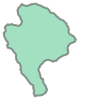

In [59]:
exploded.xs(exploded.index[2])

# calculate area
# store to list for easier handling

# KALO NGGA
# loop for every constituents
# keep track of first level value
# update with higher constituents
# store multiindex value that has highest area

# define province that belonging to one another (kalimantan, jawa, sumatera, sulawesi, papua)
# merge shapefile
# create outer boundary

# Run algorithm to check if a given point lies inside or outside polygon
# to define point: find unique extent point in demnas db

In [53]:
gpd.IndexSlice?

Object `gpd.IndexSlice` not found.


# Try to re-download broken file

Only `https://tanahair.indonesia.go.id/unduh/dembat/DEMNAS_2112-121_v1.0.tif` success. But not included in next step

In [41]:
download_path = 'http://tides.big.go.id/DEMNAS/download.php?download_file='
download_path = 'https://tanahair.indonesia.go.id/unduh/dembat/'
for el in error_list:
    el_remove_first_param = '_'.join(el.split('_')[1:])
    download_path_append = download_path + el_remove_first_param
    print(download_path_append)

https://tanahair.indonesia.go.id/unduh/dembat/DEMNAS_2108-334_v1.0.tif
https://tanahair.indonesia.go.id/unduh/dembat/DEMNAS_2306-632_v1.0.tif
https://tanahair.indonesia.go.id/unduh/dembat/DEMNAS_1316-11_v1.0.tif
https://tanahair.indonesia.go.id/unduh/dembat/DEMNAS_0715-22_v1.0.tif
https://tanahair.indonesia.go.id/unduh/dembat/DEMNAS_2112-121_v1.0.tif
https://tanahair.indonesia.go.id/unduh/dembat/DEMNAS_0518-32_v1.0.tif
https://tanahair.indonesia.go.id/unduh/dembat/DEMNAS_0518-31_v1.0.tif
https://tanahair.indonesia.go.id/unduh/dembat/DEMNAS_0517-64_v1.0.tif
https://tanahair.indonesia.go.id/unduh/dembat/DEMNAS_0518-34_v1.0.tif
https://tanahair.indonesia.go.id/unduh/dembat/DEMNAS_0518-33_v1.0.tif
https://tanahair.indonesia.go.id/unduh/dembat/DEMNAS_1115-41_v1.0.tif
https://tanahair.indonesia.go.id/unduh/dembat/DEMNAS_1015-32_v1.0.tif
https://tanahair.indonesia.go.id/unduh/dembat/DEMNAS_1015-22_v1.0.tif
https://tanahair.indonesia.go.id/unduh/dembat/DEMNAS_1114-42_v1.0.tif
https://tanahair.

https://tanahair.indonesia.go.id/unduh/dembat/0_DEMNAS_1118-631_v1.0.tif
https://tanahair.indonesia.go.id/unduh/dembat/DEMNAS_1118-631_v1.0.tif